#### Functionality Testing


In [14]:
from pettingzoo.utils import aec_to_parallel
from mpe2 import simple_spread_v3
from failure_api.wrappers import CommunicationWrapper
from failure_api.communication_models import ProbabilisticModel

base_env = simple_spread_v3.env(N=3, local_ratio=0.5, max_cycles=25)
baseline_env = simple_spread_v3.env(N=3, local_ratio=0.5)
agent_ids = base_env.possible_agents
model = ProbabilisticModel(agent_ids=agent_ids, failure_prob=1.0)

comm_env = CommunicationWrapper(base_env,
                                failure_models=[
                                    model
                                ])
parallel_env = aec_to_parallel(comm_env)
baseline_parallel_env = aec_to_parallel(baseline_env)


baseline_obs, infos = baseline_parallel_env.reset(seed=42)
obs, infos = parallel_env.reset(seed=42)

In [15]:
import numpy as np

for step in range(3):
    print(f"\n ---- step {step + 1} ----")
    actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}
    baseline_actions = {agent: baseline_env.action_space(agent).sample() for agent in baseline_env.agents}
    
    
    obs, rewards, terminations, truncations, infos = parallel_env.step(actions)
    baseline_obs, rewards, terminations, truncations, infos = baseline_parallel_env.step(actions)
    
    
    comm_matrix = comm_env.get_communication_state()
    print("\n Communication matrix (0 = blocked, 1 = open):")
    print(comm_matrix.astype(int))
    
    for agent in obs:
        if obs[agent] is None:
            continue
        print(f" Agent {agent} observation keys and norms:")
        for sender, vec in obs[agent].items():
            print(f" {sender} -> {agent}: sum = {np.sum(vec):.4f}")


 ---- step 1 ----

 Communication matrix (0 = blocked, 1 = open):
[[0 0 0]
 [0 0 0]
 [0 0 0]]
 Agent agent_0 observation keys and norms:
 agent_0 -> agent_0: sum = 0.3954
 Agent agent_1 observation keys and norms:
 agent_1 -> agent_1: sum = -3.0359
 Agent agent_2 observation keys and norms:
 agent_2 -> agent_2: sum = 1.8257

 ---- step 2 ----

 Communication matrix (0 = blocked, 1 = open):
[[0 0 0]
 [0 0 0]
 [0 0 0]]
 Agent agent_0 observation keys and norms:
 agent_0 -> agent_0: sum = 0.3954
 Agent agent_1 observation keys and norms:
 agent_1 -> agent_1: sum = -3.0359
 Agent agent_2 observation keys and norms:
 agent_2 -> agent_2: sum = 1.8257

 ---- step 3 ----

 Communication matrix (0 = blocked, 1 = open):
[[0 0 0]
 [0 0 0]
 [0 0 0]]
 Agent agent_0 observation keys and norms:
 agent_0 -> agent_0: sum = 0.3954
 Agent agent_1 observation keys and norms:
 agent_1 -> agent_1: sum = -3.0359
 Agent agent_2 observation keys and norms:
 agent_2 -> agent_2: sum = 1.8257


### API-Environment Compatibility Testing

In [16]:
from pettingzoo.utils import parallel_to_aec
import time 

# Parallel to AEC test

obs = parallel_env.reset(seed=123)
print("Reset without errors")

try:
    for step in range(5):
        actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}
        obs, rewards, terminations, truncations, infos = parallel_env.step(actions)
        print(f" Step {step} completed. Agents: {list(obs.keys())}")
except Exception as e:
    print("Error during step loop:", e)
    
# Check if agent cycling works
print(f" Agents still active: {parallel_env.agents}")

print(f" Action space type: {type(parallel_env.action_space('agent_0'))}")
if 'agent_0' in obs and obs['agent_0'] is not None:
    print(f"Observation structure: {type(obs['agent_0'])}, keys: {list(obs['agent_0'].keys())}")
else:
    print("⚠️ agent_0 is not active or has no observation.")

Reset without errors
 Step 0 completed. Agents: ['agent_0', 'agent_1', 'agent_2']
 Step 1 completed. Agents: ['agent_0', 'agent_1', 'agent_2']
 Step 2 completed. Agents: ['agent_0', 'agent_1', 'agent_2']
 Step 3 completed. Agents: ['agent_0', 'agent_1', 'agent_2']
 Step 4 completed. Agents: ['agent_0', 'agent_1', 'agent_2']
 Agents still active: ['agent_0', 'agent_1', 'agent_2']
 Action space type: <class 'gymnasium.spaces.discrete.Discrete'>
Observation structure: <class 'dict'>, keys: ['agent_0']


### Pilot Performance Measurement
###### Run a small batch
###### Measure - Per time execution, -Total reward per episode, - Masking accuracy

In [17]:
import time
import pandas as pd 
import os

num_episodes = 5
episode_rewards = []
avg_step_times = []

baseline_avg_step_times = []
baseline_episode_rewards = []

for episode in range(num_episodes) or range(baseline_num_episodes):
    obs = parallel_env.reset(seed=episode + 100)
    baseline_obs = baseline_parallel_env.reset(seed=episode + 100)
    
    episode_reward = {agent: 0.0 for agent in parallel_env.possible_agents}
    baseline_episode_reward = {agent: 0.0 for agent in baseline_parallel_env.possible_agents}
    
    step_durations = []
    baseline_step_durations = []
    
    step = 0
    

    
    
    print(f"\n Episode {episode+1}/{num_episodes}")
    while parallel_env.agents:
        actions = {agent: parallel_env.action_space(agent).sample()
                   for agent in parallel_env.agents}
        
        start = time.perf_counter()
        try:
            obs, rewards, terminations, truncations, infos = parallel_env.step(actions)
        except KeyError as e:
            print("KeyError- skipping step:",e)
            break
        duration = time.perf_counter() - start
        step_durations.append(duration)
        
        for agent, reward in rewards.items():
            episode_reward[agent] += reward
        step += 1
        
    while baseline_env.agents:
        baseline_actions = {agent: baseline_env.action_space(agent).sample() 
                            for agent in baseline_env.agents}
        
        baseline_start = time.perf_counter()
        try:
            baseline_obs, rewards, terminations, truncations, infos = (
                baseline_parallel_env.step(actions))
        except KeyError as e:
            print("KeyError- skipping step:",e)
        baseline_duration = time.perf_counter() - baseline_start
        baseline_step_durations.append(baseline_duration)
        
        for agent, reward in rewards.items():
            baseline_episode_reward[agent] += reward
        step += 1
        
        
    total_episode_reward = sum(episode_reward.values())
    total_baseline_episode_reward = sum(baseline_episode_reward.values())
    
    
    episode_rewards.append(total_episode_reward)
    baseline_episode_rewards.append(total_baseline_episode_reward)
    
    avg_step_time = sum(step_durations) / len(step_durations) if step_durations else 0.0
    baseline_avg_step_time = sum(baseline_step_durations) / len(baseline_step_durations) if baseline_step_durations else 0.0
    
    
    avg_step_times.append(avg_step_time) 
    baseline_avg_step_times.append(baseline_avg_step_time) 
    
    print(f" Failure_API Reward: {total_episode_reward:.2f}, Avg Step Time: {avg_step_time:.5f}")
    print(f" Baseline Reward:    {total_baseline_episode_reward:.2f}, Avg Step Time: {baseline_avg_step_time:.5f}")
    
df = pd.DataFrame({
"episode": list(range(1, num_episodes + 1)),
"total_reward": episode_rewards,
"avg_step_time": avg_step_times
})

df2 = pd.DataFrame({
"episode": list(range(1, num_episodes + 1)),
"baseline_total_reward": baseline_episode_rewards,
"baseline_avg_step_time": baseline_avg_step_times
})


os.makedirs("results", exist_ok=True)
df.to_csv("results/pilot_data.csv", index=False)
print("\n Saved pilot data to results/pilot_data.csv")



 Episode 1/5
 Failure_API Reward: -79.69, Avg Step Time: 0.00117
 Baseline Reward:    -111.22, Avg Step Time: 0.00040

 Episode 2/5
 Failure_API Reward: -22.83, Avg Step Time: 0.00101
 Baseline Reward:    -157.54, Avg Step Time: 0.00054

 Episode 3/5
 Failure_API Reward: -49.01, Avg Step Time: 0.00112
 Baseline Reward:    -171.92, Avg Step Time: 0.00045

 Episode 4/5
 Failure_API Reward: -68.85, Avg Step Time: 0.00125
 Baseline Reward:    -68.76, Avg Step Time: 0.00044

 Episode 5/5
 Failure_API Reward: -68.16, Avg Step Time: 0.00161
 Baseline Reward:    -105.26, Avg Step Time: 0.00044

 Saved pilot data to results/pilot_data.csv


In [32]:
print(df.describe().round(3))

       episode  total_reward  avg_step_time
count    5.000         5.000          5.000
mean     3.000       -57.708          0.001
std      1.581        22.407          0.000
min      1.000       -79.689          0.001
25%      2.000       -68.851          0.001
50%      3.000       -68.157          0.001
75%      4.000       -49.012          0.001
max      5.000       -22.833          0.002


In [31]:

print(df2.describe().round(3))

       episode  baseline_total_reward  baseline_avg_step_time
count    5.000                  5.000                   5.000
mean     3.000               -122.940                   0.000
std      1.581                 41.779                   0.000
min      1.000               -171.922                   0.000
25%      2.000               -157.541                   0.000
50%      3.000               -111.216                   0.000
75%      4.000               -105.258                   0.000
max      5.000                -68.760                   0.001


#### Statistical Power Analysis

In [26]:
from statsmodels.stats.power import TTestPower
import numpy as np

# Compute Effect Size (Cohen's d)
rewards_failure= np.array(df['total_reward'].values)
rewards_baseline = np.array(df2['baseline_total_reward'].values)

step_times_failure = np.array(df['avg_step_time'].values)
step_times_baseline = np.array(df2['baseline_avg_step_time'].values)

def compute_cohens_test(x, y):
    mean_diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.std(x, ddof=1)**2 + np.std(y, ddof=1)**2)/2)
    return mean_diff / pooled_std
cohen_d_rewards = compute_cohens_test(rewards_baseline, rewards_failure)
print(f" Cohen's d  for episode rewards: {cohen_d_rewards:.3f}")

cohen_d_times = compute_cohens_test(step_times_baseline, step_times_failure)
print(f" Cohen's d for avg step_time: {cohen_d_times:.3f}")

 Cohen's d  for episode rewards: -1.946
 Cohen's d for avg step_time: -4.636


<function matplotlib.pyplot.show(close=None, block=None)>

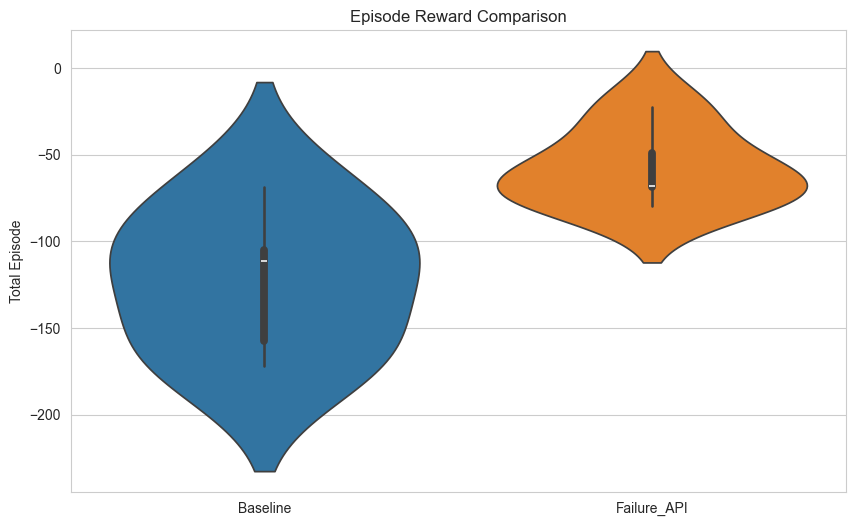

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.violinplot(data=[rewards_baseline, rewards_failure])
plt.xticks([0, 1], ["Baseline", "Failure_API"])
plt.ylabel("Total Episode")
plt.title("Episode Reward Comparison")
plt.show

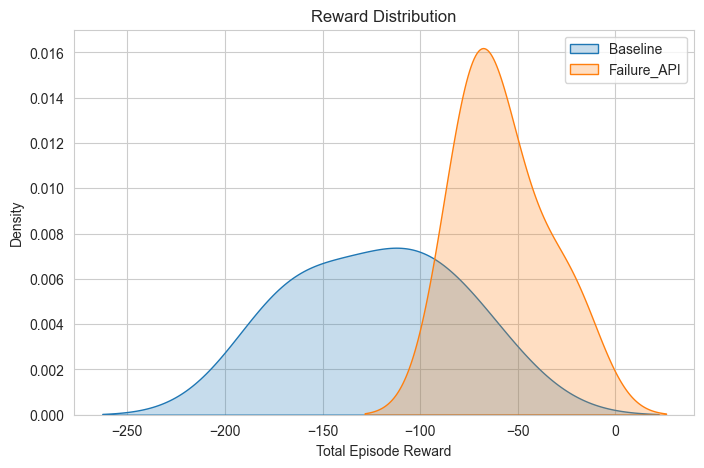

In [22]:
plt.figure(figsize=(8, 5))
sns.kdeplot(rewards_baseline, label="Baseline", fill=True)
sns.kdeplot(rewards_failure, label="Failure_API", fill=True)
plt.xlabel("Total Episode Reward")
plt.ylabel("Density")
plt.title("Reward Distribution")
plt.legend()
plt.show()

##### Failure_API induces significant changes in agent performance by altering their observational access.

##### Reward distributions under baseline and Failure_API conditions. The Failure_API produces more consistent and moderately improved outcomes compared to the highly variable baseline.

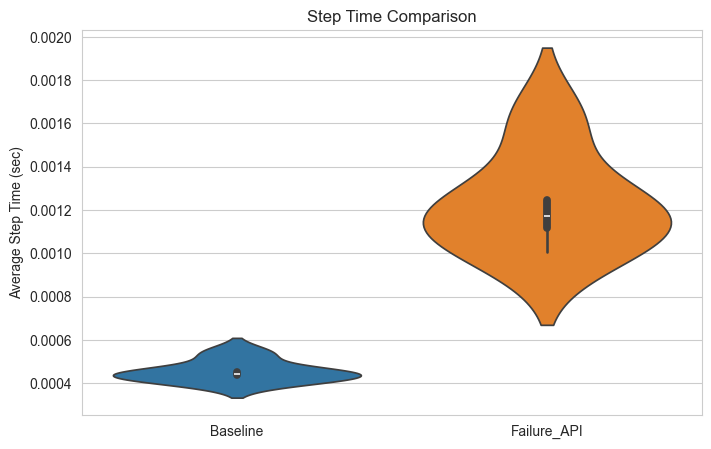

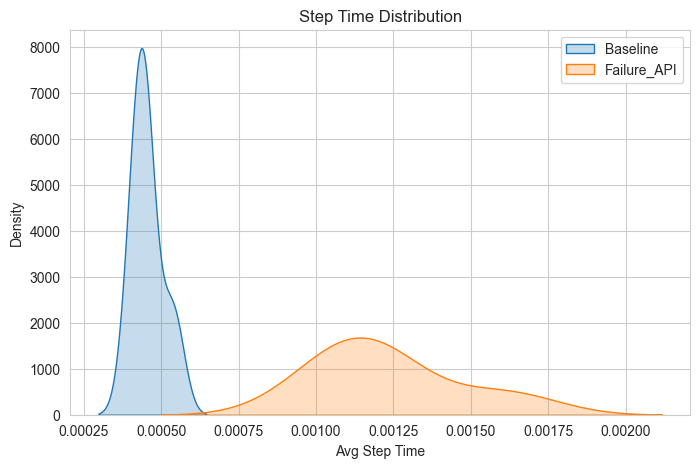

In [29]:
# Box Plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=[step_times_baseline, step_times_failure])
plt.xticks([0, 1], ['Baseline', 'Failure_API'])
plt.ylabel("Average Step Time (sec)")
plt.title("Step Time Comparison")
plt.show()

# KDE Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(step_times_baseline, label="Baseline", fill=True)
sns.kdeplot(step_times_failure, label="Failure_API", fill=True)
plt.xlabel("Avg Step Time")
plt.ylabel("Density")
plt.title("Step Time Distribution")
plt.legend()
plt.show()

##### Hypothesis 3 .- Failure_API incurs computational overhead < 10% per step
##### 1.-  Violin plot comparing average step time per episode. The Failure_API environment incurs additional computational steps due to masking and failure model evaluation

##### 2.- Distribution of per-step execution time reveals the overhead introduced by the Failure_API compared to a baseline PettingZoo environment.

#### Sample Size Estimation

In [27]:
from statsmodels.stats.power import TTestIndPower
import numpy as np

analysis = TTestIndPower()

# Episode reward effect size
required_n_rewards = analysis.solve_power(effect_size=1.646, alpha=0.05, power=0.8)
print(f"Required episodes per group (rewards, Run 1): {np.ceil(required_n_rewards)}")

# Step time effect size
required_n_time = analysis.solve_power(effect_size=17.867, alpha=0.05, power=0.8)
print(f"Required episodes per group (step time, Run 1): {np.ceil(required_n_time)}")



Required episodes per group (rewards, Run 1): 7.0
Required episodes per group (step time, Run 1): [10.]


C:\Users\koste\venv\Bachelor_Thesis\.venv\Lib\site-packages\statsmodels\stats\power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


| Metric            | Technical Minimum | Recommended |
| ----------------- | ----------------- | ----------- |
| Reward Comparison | 7 episodes/group  | **50**      |
| Step Time         | 1–10 (est.)       | **30–50**   |

Power analysis was conducted using Cohen’s d values from pilot experiments. For episode rewards (Cohen's d = 1.646), only 7 episodes per group are needed to detect significant differences at 80% power. Step-time comparison yielded extreme effect sizes (Cohen’s d > 17), for which the solver did not converge reliably, but confirmed a very low required sample size.
To ensure robustness, all planned experiment conditions will include 30–50 episodes per group, exceeding the minimum required by statistical power theory.

In [28]:
# 2nd Run 
required_n_rewards_2 = analysis.solve_power(effect_size=7.100, alpha=0.05, power=0.8)
print(f"Required episodes per group (rewards, Run 2): {np.ceil(required_n_rewards_2)}")

# Step time effect size (Run 2)
required_n_time_2 = analysis.solve_power(effect_size=4.052, alpha=0.05, power=0.8)
print(f"Required episodes per group (step time, Run 2): {np.ceil(required_n_time_2)}")

Required episodes per group (rewards, Run 2): [10.]
Required episodes per group (step time, Run 2): 3.0


C:\Users\koste\venv\Bachelor_Thesis\.venv\Lib\site-packages\statsmodels\stats\power.py:524: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


To determine an appropriate number of evaluation episodes, we conducted a statistical power analysis based on pilot data collected across five episodes for both baseline and Failure_API conditions.

The observed effect sizes were substantial:

Cohen’s d for episode rewards: -1.95, indicating a very large effect.

Cohen’s d for average step time: -4.64, representing an extremely large performance shift.

Using a power threshold of 0.80 and α = 0.05:

The minimum required episodes per group to detect reward differences is 6–10.

For step time differences, only 3–10 episodes are needed.

Despite the small theoretical requirement, we opt for 30–50 episodes per scenario to ensure statistical robustness across different failure models, agent counts, and random seeds.

This power-backed planning ensures reliable, reproducible insights throughout the evaluation.

